In [3]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import MDAnalysis

In [25]:
#################################################
#             Input parameters                  #
#################################################

reference = 'wt_prot_rottrans'
deformed = 'md_prot_rottrans'
out = 'outfile'
atom_selection = 'resid 307-397 and name CA'
cutoff = 10
stride_ref = 1000
stride_def = 1000

gro1 = reference + '.pdb'
xtc1 = reference + '.xtc'
gro2 = deformed + '.pdb'
xtc2 = deformed + '.xtc'

bar_fig = out +'_bar.svg'
strain_fig = out + '_strain.svg'
loaduser_file = out + '_strain_loaduser.dat'
strain_file = out + '_strain.dat'
sem_file = out + '_sem.dat'

In [26]:
##################################################
#             Loading trajectories               #
##################################################

traj1 = MDAnalysis.Universe(gro1, xtc1)
sele1 = traj1.select_atoms(atom_selection)
traj2 = MDAnalysis.Universe(gro2, xtc2)
sele2 = traj2.select_atoms(atom_selection)
if len(sele1) != len(sele2):
    raise Exception("The nr of atoms in both gro files don't match after truncation; reconsider your atom_selection argument")
resids = sele1.resids

In [27]:
##################################################
# Shear strain calculation (pairwise comparison) #
##################################################
R = cutoff
strain_dyn = []

strain_raw = np.zeros((sele1.atoms.n_atoms))
strain_sum = np.zeros((sele1.atoms.n_atoms))

step = 0
maxstep = len(traj1.trajectory[::stride_ref])*len(traj2.trajectory[::stride_def])
for ts1 in traj1.trajectory[::stride_ref]:
    x0 = sele1.positions
    dis_x0 = MDAnalysis.lib.distances.distance_array(x0, x0)
    for ts2 in traj2.trajectory[::stride_def]:
        step += 1
        x = sele2.positions
        tensor = []
        shear = []

        for i in range(len(x0)):
            B = []
            A = []


            for j in range(len(x0)):
                if dis_x0[i,j] < R and dis_x0[i,j] != 0.:
                    A.append(x0[j] - x0[i])
                    B.append(x[j] - x[i])
            Am = np.array(A)
            Bm = np.array(B)
            D = np.linalg.inv(Am.transpose()@Am)
            D = np.linalg.inv(Am.transpose()@Am)
            C = Bm@Bm.transpose() - Am@Am.transpose()
            Q = 0.5*(D@Am.transpose()@C@Am@D)

            tensor.append(Q)
            s = np.trace(Q@Q) - (1/3)*(np.trace(Q))**2
            shear.append(s)

        if step % int(maxstep/100) == 0:
            flog = open('strain.log','a+')
            flog.write('%d %% completed\n' % (step/int(maxstep/100)))
            flog.close()
        #shear = list(zip(shear, names, resids))
        #tensor =  list(zip(tensor, resids))
        #strain_dyn.append(shear)
        strain_raw = np.vstack((strain_raw,np.asarray(shear)))

strain_avg = np.average(strain_raw[1:], axis=0)
sem = stats.sem(strain_raw[1:],axis=0)

###############################################################################

In [28]:
strain_avg

array([0.10750508, 0.03822402, 0.03109089, 0.03072375, 0.0137885 ,
       0.01429663, 0.01350505, 0.02914275, 0.02613579, 0.03478256,
       0.06661178, 0.06689369, 0.215961  , 0.21857442, 0.19929208,
       0.0663267 , 0.04131593, 0.0250079 , 0.00894249, 0.01269021,
       0.01165542, 0.02236787, 0.08527887, 0.41374748, 0.21341461,
       0.25381523, 0.34003483, 0.28924119, 0.09589924, 0.02466337,
       0.01143242, 0.00581441, 0.00993034, 0.0102768 , 0.00950671,
       0.01622521, 0.02316503, 0.0503688 , 0.02425303, 0.02032047,
       0.01162833, 0.0106173 , 0.018645  , 0.04570803, 0.02828918,
       0.03535758, 0.01263706, 0.01315247, 0.01227533, 0.00960847,
       0.00621178, 0.00929702, 0.00945164, 0.01343262, 0.01596022,
       0.02767556, 0.09862972, 0.06089138, 0.06125728, 0.03529565,
       0.03136387, 0.12321829, 0.15313801, 0.0846485 , 0.05519104,
       0.05736181, 0.06474921, 0.06371146, 0.02937717, 0.03178158,
       0.03338328, 0.04512679, 0.03521748, 0.0680312 , 0.15374

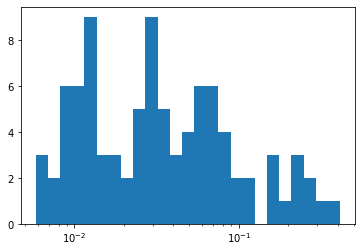

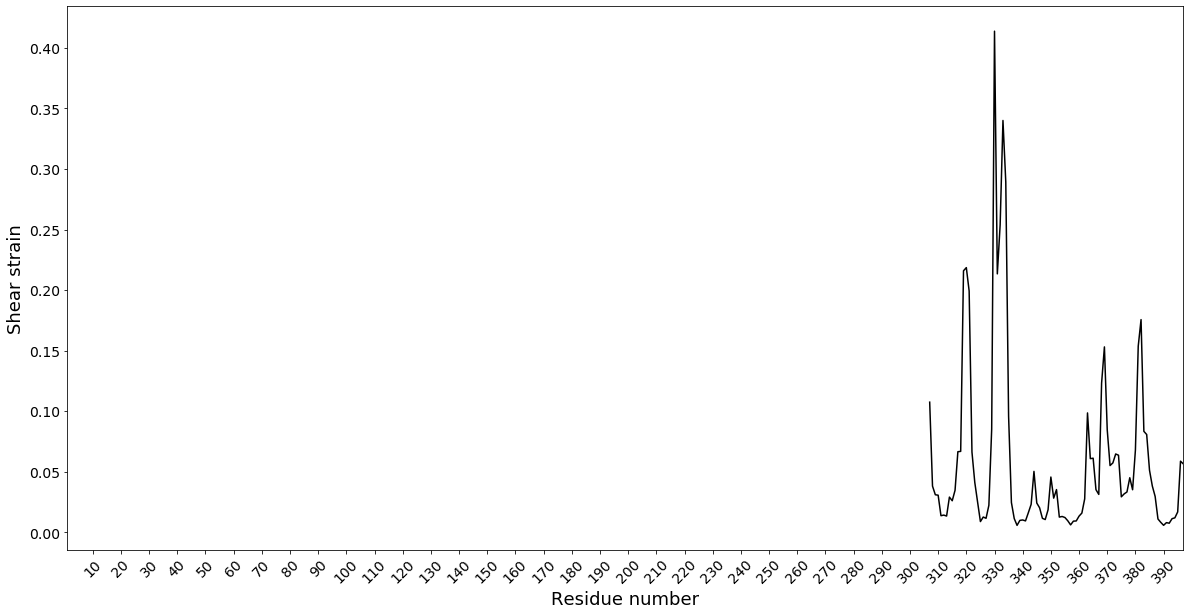

In [29]:
##############################################
#             Plotting graphs                #
##############################################


average = list(zip(strain_avg, resids))

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

plot_loghist(strain_avg,25)
plt.savefig(bar_fig, format='svg')


x = np.arange(resids[0],resids[-1]+1)

fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_xlabel('Residue number',fontsize=18)
ax1.set_ylabel('Shear strain',fontsize=18)
ax1.plot(x,strain_avg,color='k')
ax1.set_xlim(left=1,right=resids[-1])
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
plt.locator_params(axis='x',nbins=50)
plt.xticks(rotation=45)
plt.savefig(strain_fig, format='svg')
plt.show()


In [30]:
#############################################
#         Write output to file              #
#############################################

fload = open(loaduser_file,'w')
for kk in range(sele1.atoms.n_atoms):
    for jj in range(len(average)):
        if sele1.atoms.resids[kk] == average[jj][1]:
            fload.write('%.16f ' % average[jj][0])
fload.close()

fstrain = open(strain_file,'w')
for kk in range(sele1.atoms.n_atoms):
    fstrain.write('%d %16f\n' % (x[kk], strain_avg[kk]))
fstrain.close()

fsem = open(sem_file,'w')
for kk in range(sele1.atoms.n_atoms):
    fsem.write('%.16f\n' % sem[kk])
fsem.close()